In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torch.optim as optim

from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_dataset = FashionMNIST(root=".", download=True, train=True, transform=ToTensor())
val_dataset = FashionMNIST(root=".", download=True, train=False, transform=ToTensor())

len(train_dataset), len(val_dataset)

100%|██████████| 26421880/26421880 [00:08<00:00, 2986222.13it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175758.62it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3261678.09it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6365647.70it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(60000, 10000)

In [4]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

In [5]:
val_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

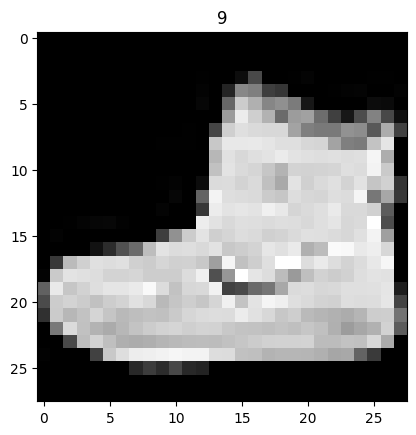

In [6]:
plt.imshow(image.permute(1,2,0), cmap="gray")
plt.title(label)
plt.show()

In [17]:
class AutoencModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(128 * 4 * 4,128),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,2),

    )

    self.decoder = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 128),
        nn.ReLU(),
        nn.Linear(128, 128 * 4 * 4),
        nn.ReLU(),
        nn.Unflatten(1, (128,4,4)),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1),
        nn.Sigmoid()

    )

  def forward(self, X):
    enc = self.encoder(X)
    dec = self.decoder(enc)
    return dec, enc

In [18]:
summary(AutoencModel().to(device), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             320
              ReLU-2           [-1, 32, 13, 13]               0
            Conv2d-3             [-1, 64, 6, 6]          18,496
              ReLU-4             [-1, 64, 6, 6]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                  [-1, 128]         262,272
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 32]           4,128
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 2]              66
           Linear-13                   [-1, 32]              96
             ReLU-14                   

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [19]:
EPOCHS = 10
model = AutoencModel()

model.to(device)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []

for _ in range(EPOCHS):
  model.train()
  mini_batch_loss = []
  for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)

    optimizer.zero_grad()

    yhat, _ = model(x_batch)

    loss = loss_fn(yhat, x_batch)
    mini_batch_loss.append(loss.item())

    loss.backward()

    optimizer.step()

  losses.append(np.mean(mini_batch_loss))

  print("A epoch completed")

A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed
A epoch completed


In [20]:
model = model.to("cpu")

In [21]:
val_loader = DataLoader(val_dataset, batch_size=12)

In [22]:
sample_batch = None
for x, _ in val_loader:
  sample_batch =  x
  break
sample_batch.shape

torch.Size([12, 1, 28, 28])

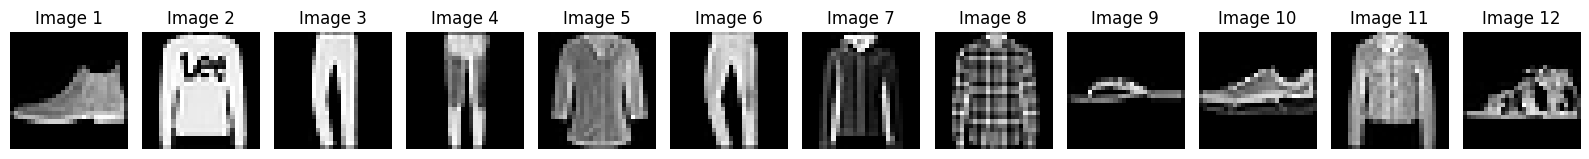

In [23]:
fig, axs = plt.subplots(1, 12, figsize=(16, 16))

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(sample_batch[i][0], cmap='gray')
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
with torch.no_grad():
  yhat, _ = model(sample_batch)

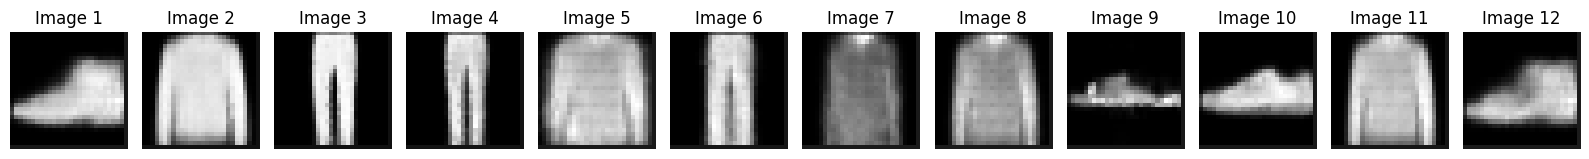

In [25]:
fig, axs = plt.subplots(1, 12, figsize=(16, 16))

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(yhat[i][0], cmap='gray')
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [33]:
val_loader = DataLoader(val_dataset, batch_size=32)
latent_representations = []
labels = []

with torch.no_grad():
    for data, target in val_loader:
        _, z = model(data)
        latent_representations.append(z)
        labels.append(target)


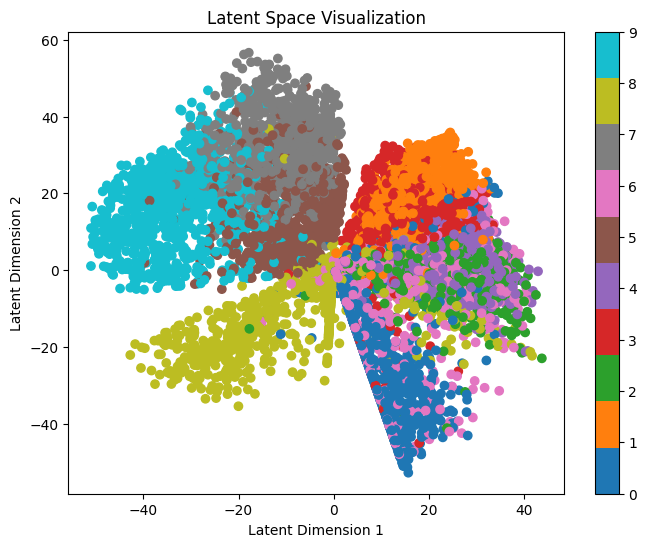

In [34]:
latent_representations = torch.cat(latent_representations).numpy()
labels = torch.cat(labels).numpy()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()